## This notebook reads in the AACSE publicly available earthquake catalog and downloads associated waveforms to begin to explore the data. 

In [7]:
import obspy
import matplotlib.pyplot as plt
import numpy as np
import glob2 as glob
import pandas as pd
import time; import datetime
from obspy.core.utcdatetime import UTCDateTime
from obspy.clients.fdsn.client import Client

## Start by going online to download the AACSE earthquake catalog, which is split into two parts:  
May-December 2018 https://scholarworks.alaska.edu/handle/11122/11418 \
January-August 2019 https://scholarworks.alaska.edu/handle/11122/11967 \
The download for each is a tar file that decompresses into several whitespace-delimited files, one for each month, and a quakeML file for each month. 

## The non-quakeML files are in the CSS format, details of which can be found here:  
https://l2a.ucsd.edu/local/Manuals/CSS3.0_Format_Manual.pdf  

In [8]:
def read_files(base_folder):
    ''' Reads in earthquake catalog files from CSS format into useful pandas dataframes
    
        Inputs:
        base_folder = string containing name of year and month of interest, e.g. '2019_01'
        
        Outputs dataframes:
        assoc
        arrivals
        origin
    '''
    
    
    base_dir = 'catalog_css/'+base_folder+'/'
    
    arr_files = glob.glob(base_dir + 'catalog_XO_*arrival')
    assoc_files = glob.glob(base_dir + 'catalog_XO_*assoc')
    origin_files = glob.glob(base_dir + 'catalog_XO_*origin')
    
    # Read data into pandas dataframe
    arrivals = pd.concat([pd.read_csv(f,header=None,delim_whitespace=True) for f in arr_files])
    assoc = pd.concat([pd.read_csv(f,header=None,delim_whitespace=True) for f in assoc_files])
    origin = pd.concat([pd.read_csv(f,header=None,delim_whitespace=True) for f in origin_files])

    # Rename some columns for clarity:
    assoc=assoc.rename(columns={0: "arrivalid", 1: "originid",2:"stationcode",3:"phase"})
    origin = origin.rename(columns={4:'originid',3:'epochtime'})
    arrivals=arrivals.rename(columns={2: "arrivalid", 6: "channel",0:"stationcode", 1:'epochtime'})
    
    return(assoc,arrivals,origin)

The following cell does a simplified process, where it doesn't check for which channels detected a pick for which event, but instead just goes with a subset of chosen stations and pulls the stream for each origin time regardless of whether the station had a pick or not.  

## The metadata associated with all stations in the XO network can be found here:  
http://ds.iris.edu/mda/XO/?starttime=2018-01-01T00:00:00&endtime=2019-12-31T23:59:59  

## To start, I have selected 6 stations in various parts of the network - 1 deep WHOI OBS, 1 deep Lamont OBS, 1 shallow TRM Lamont OBS, 2 island-based stations, and 1 land-based station on the far side of the AK Peninsula.

In [ ]:
stations = 'WD65,WD65,WD65,LA21,LA21,LA21,LT08,LT08,LT08,WS27,WS27,WS27,KD05,KD05,KD05,EP16,EP16,EP16'
channels = 'HHZ,HH1,HH2,HHZ,HH1,HH2,HHZ,HH1,HH2,HHZ,HHE,HHN,HHZ,HHE,HHN,HHZ,HHE,HHN'
stations = 'WD65,LA21,LT08,WS27,KD05,EP16'
channels = 'HHZ,HHZ,HHZ,HHZ,HHZ,HHZ'

stream = obspy.core.stream.Stream()

# Need to do each month separately since the event origin index restarts
months = ['2018_05','2018_06','2018_07','2018_08','2018_09','2018_10','2018_11','2018_12','2019_01','2019_02','2019_03']
months = ['2018_08','2018_09']

# Loop over months:
for month in months:
    print(month)
    # Read in files for that month:
    (assoc,arrivals,origin) = read_files(month)
    # Get list of origin IDs in that month:
    origin_ids = np.unique(assoc['originid'])
    
    # Loop over events within that month:
    for origin_id in origin_ids:


        # This is the origin time of the event:
        origin_epoch = origin['epochtime'].loc[origin['originid']==origin_id]
        basetime = datetime.datetime.utcfromtimestamp(origin_epoch).strftime('%Y-%m-%dT%H:%M:%S.%m')
        # We want the streams for 20 minutes before and after the origin time:
        t1 = UTCDateTime(basetime)-datetime.timedelta(minutes = 20)
        t2 = UTCDateTime(basetime)+datetime.timedelta(minutes = 20)

        # Now we query the data from IRIS for each of the stations 20 min before and after the origin time, and add it to the master stream:
        client = Client("IRIS")
        try:
            # Download the streams INCLUDING the instrument response:
            st = client.get_waveforms("XO",stations, "--",channels, t1, t2,attach_response=True)
            # Remove the instrument response from the downloaded stream:
            st.remove_response()
            # Append to overall stream:
            stream = stream + st
        except:
            continue
print(print(stream.__str__(extended=True)))

In [ ]:
# Save stream to h5 file

# stream.write('2018_08-09.h5','h5')

# Read it back in!

obspy.read('2018_08-09.h5')

## Below plots and looks at individual waveforms, centered on their arrival times, to get a sense of the range of time in which events fall into the time window.

      stationcode     epochtime  arrivalid        3  4      5 channel  7  8  \
16536        WD48  1.537045e+09      16537  2018258 -1  21161     HHZ  P  -   
16537        KS03  1.537045e+09      16538  2018258 -1  20687     HHZ  P  -   

           9  ...   16   17     18  19  20       21  22   23  24            25  
16536  0.053  ... -1.0 -1.0 -999.0   -   -  13.3650   -  new  -1  1.601597e+09  
16537  0.057  ... -1.0 -1.0 -999.0   -   -   9.8002   -  new  -1  1.601597e+09  

[2 rows x 26 columns]


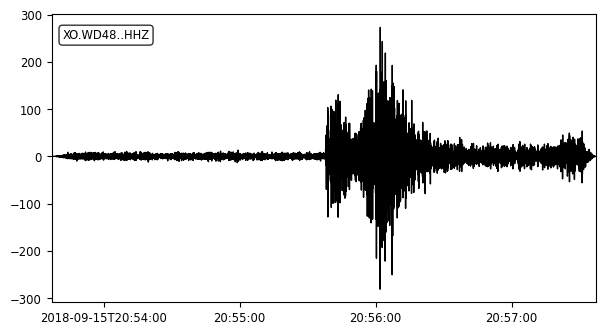

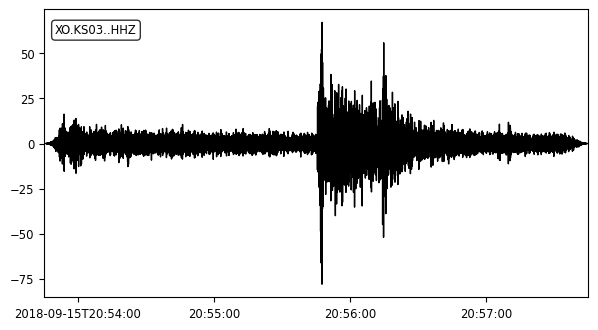

In [9]:
month = '2018_09'
ml_path = 'catalog_css/'+month+'/XO_'+month+'.quakeml'
(assoc,arrivals,origin) = read_files(month)
# Get list of origin IDs in that month:
origin_ids = np.unique(assoc['originid'])

origin_id = origin_ids[310]


subset = assoc.loc[assoc['originid']==origin_id]
# Get the arrivals associated with those arrival ids (they match the index, just needs to be adjusted to starting with 0):
arrival_subset = arrivals.iloc[subset['arrivalid']-1]
arrival_subset = arrival_subset[4:6]
print(arrival_subset)

# Make a list of the station codes and channel codes associated with those arrivals
# in the format that obspy requires
stations = ''
channels = ''
for i in range(len(arrival_subset)):
    # Skip weird channels:
    if len(arrival_subset['channel'].iloc[i])>3:
        continue
    stations = arrival_subset['stationcode'].iloc[i]
    channels = arrival_subset['channel'].iloc[i]

    # This is the arrival time:
    origin_epoch = arrival_subset['epochtime'].iloc[i]
    basetime = datetime.datetime.utcfromtimestamp(origin_epoch).strftime('%Y-%m-%dT%H:%M:%S.%m')
    # We want the streams for 20 minutes before and after the arrival time:
    t1 = UTCDateTime(basetime)-datetime.timedelta(minutes = 2)
    t2 = UTCDateTime(basetime)+datetime.timedelta(minutes = 2)


    # Now we query the data from IRIS for each of the stations 20 min before and after the origin time, and add it to the master stream:
    client = Client("IRIS")
    # Download the streams INCLUDING the instrument response:
    st = client.get_waveforms("XO",stations, "--",channels, t1, t2,attach_response = True)
    # Remove the instrument response from the downloaded stream                           
    st.detrend("linear")
    st.taper(max_percentage=0.05, type="hann")
    st.filter('bandpass',freqmin=4,freqmax=10)

    # Plot the waveform!
    fig = plt.figure()
    st.plot(fig = fig)  
    plt.show(fig)
    
    # plt.axvline(x=basetime,linewidth=2, color='r')                               


## How frequently do events occur in the catalog? Let's look at their interevent times.

(0.0, 15.0)

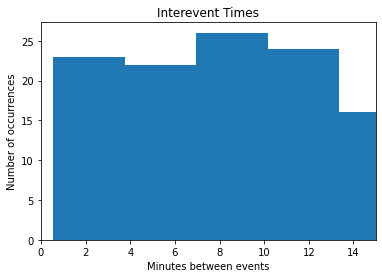

In [12]:
month = '2018_05'

(assoc,arrivals,origin) = read_files(month)

origin.head()

# Epoch time is in seconds, so the difference is given in seconds:
gaps = origin['epochtime'].diff()

# Convert that to minutes:
gaps = gaps / 60


fig = plt.figure()
plt.hist(gaps[0:407],bins=200)
plt.xlabel('Minutes between events')
plt.ylabel('Number of occurrences')
plt.title('Interevent Times')
plt.xlim([0,15])


Looping over one event at a time, get a list of stations that had a pick for that event, and for each of them, query the waveforms from IRIS for 20 min before and after the origin time of the event.

In [ ]:
stream = obspy.core.stream.Stream()

# Need to do each month separately since the event origin index restarts
months = ['2018_05','2018_06','2018_07','2018_08','2018_09','2018_10','2018_11','2018_12','2019_01','2019_02','2019_03']

for month in months:
    # Read in files for that month:
    (assoc,arrivals,origin) = read_files(month)
    # Get list of origin IDs in that month:
    origin_ids = np.unique(assoc['originid'])
    for origin_id in origin_ids:

        print(origin_id)

        # For one event at a time:

        # The assoc file associates between arrivals and origins.
        # Get the arrival ids associated with the desired origin ID:
        subset = assoc.loc[assoc['originid']==origin_id]
        # Get the arrivals associated with those arrival ids (they match the index, just needs to be adjusted to starting with 0):
        arrival_subset = arrivals.iloc[subset['arrivalid']-1]


        # Make a list of the station codes and channel codes associated with those arrivals
        # in the format that obspy requires
        stations = ''
        channels = ''
        for i in range(len(arrival_subset)):
            # Skip weird channels:
            if len(arrival_subset['channel'].iloc[i])>3:
                continue
            if len(stations)==0:
                stations = stations+arrival_subset['stationcode'].iloc[i]
                channels = channels+arrival_subset['channel'].iloc[i]
            else:
                stations = stations+','+arrival_subset['stationcode'].iloc[i]
                channels = channels+','+arrival_subset['channel'].iloc[i]

        # This is the origin time of the event:
        origin_epoch = origin['epochtime'].loc[origin['originid']==origin_id]
        basetime = time.strftime('%Y-%m-%dT%H:%M:%S.%m', time.localtime(origin_epoch))
        # We want the streams for 20 minutes before and after the origin time:
        t1 = UTCDateTime(basetime)-datetime.timedelta(minutes = 20)
        t2 = UTCDateTime(basetime)+datetime.timedelta(minutes = 20)

        # Now we query the data from IRIS for each of the stations 20 min before and after the origin time, and add it to the master stream:
        client = Client("IRIS")
        st = client.get_waveforms("XO",stations, "--",channels, t1, t2)
        stream = stream + st
print(print(stream.__str__(extended=True)))

### Below - SCRATCH

In [68]:
# Read CSS files into pandas dataframes - this for all

base_dir2019 = 'catalog_XO_2019_Jan-Mar/'
base_dir2018 = 'catalog_XO_2018/'
arr_files = glob.glob(base_dir2018 + '/**/catalog*arrival',recursive=True)
arr_files.extend(glob.glob(base_dir2019 + 'catalog*arrival'))
assoc_files = glob.glob(base_dir2019 + 'catalog*assoc')
assoc_files.extend(glob.glob(base_dir2018 + '/**/catalog*assoc',recursive=True))
origin_files = glob.glob(base_dir2019 + 'catalog*origin')
origin_files.extend(glob.glob(base_dir2018 + '/**/catalog*origin',recursive=True))

# Read data into pandas dataframe
#data = pd.concat([pd.read_csv(f[0]) for f in arr_files])
arrivals = pd.concat([pd.read_csv(f,header=None,delim_whitespace=True) for f in arr_files])
assoc = pd.concat([pd.read_csv(f,header=None,delim_whitespace=True) for f in assoc_files])
origin = pd.concat([pd.read_csv(f,header=None,delim_whitespace=True) for f in origin_files])

# Rename some columns for clarity:
assoc=assoc.rename(columns={0: "arrivalid", 1: "originid",2:"stationcode",3:"phase"})
origin = origin.rename(columns={4:'originid',3:'epochtime'})
arrivals=arrivals.rename(columns={2: "arrivalid", 6: "channel",0:"stationcode"})

assoc.describe()
origin.describe()

['catalog_XO_2018/2018_12/catalog_XO_2018_12.arrival', 'catalog_XO_2018/2018_07/catalog_XO_2018_07.arrival', 'catalog_XO_2018/2018_09/catalog_XO_2018_09.arrival', 'catalog_XO_2018/2018_08/catalog_XO_2018_08.arrival', 'catalog_XO_2018/2018_06/catalog_XO_2018_06.arrival', 'catalog_XO_2018/2018_11/catalog_XO_2018_11.arrival', 'catalog_XO_2018/2018_10/catalog_XO_2018_10.arrival', 'catalog_XO_2018/2018_05/catalog_XO_2018_05.arrival', 'catalog_XO_2019_Jan-Mar/catalog_XO_2019_03.arrival', 'catalog_XO_2019_Jan-Mar/catalog_XO_2019_02.arrival', 'catalog_XO_2019_Jan-Mar/catalog_XO_2019_01.arrival']


,0,1,2,epochtime,originid,5,6,7,8,9,...,11,14,16,17,18,19,20,21,24,25
count,5025.000000,5025.000000,5025.000000,5.025000e+03,5025.000000,5025.000000,5.025000e+03,5025.000000,5025.000000,5025.0,...,5025.000000,5025.0,5025.000000,5025.0,5025.000000,5025.0,5025.000000,5025.000000,5025.0,5.025000e+03
mean,56.554368,-153.776489,34.354494,1.538577e+09,240.526368,241.419104,2.018427e+06,55.871443,55.863483,-1.0,...,0.999801,-999.0,-992.411622,-1.0,-996.801751,-1.0,2.267914,523.404179,-1.0,1.608514e+09
std,1.373877,4.169492,36.920132,8.218477e+06,150.974751,152.074039,3.507300e+02,46.789871,46.739551,0.0,...,0.014107,0.0,81.040491,0.0,46.937063,0.0,0.687420,261.731795,0.0,6.533908e+06
min,52.390000,-163.073100,0.007000,1.526096e+09,1.000000,1.000000,2.018132e+06,8.000000,8.000000,-1.0,...,0.000000,-999.0,-999.000000,-1.0,-999.000000,-1.0,0.200000,1.000000,-1.0,1.602631e+09
25%,55.839600,-156.279300,10.325900,1.531364e+09,115.000000,115.000000,2.018193e+06,27.000000,27.000000,-1.0,...,1.000000,-999.0,-999.000000,-1.0,-999.000000,-1.0,1.730000,341.000000,-1.0,1.602699e+09
50%,56.305300,-153.833000,15.060000,1.537303e+09,229.000000,229.000000,2.018261e+06,40.000000,40.000000,-1.0,...,1.000000,-999.0,-999.000000,-1.0,-999.000000,-1.0,2.320000,529.000000,-1.0,1.605129e+09
75%,57.712200,-149.599000,49.749700,1.545798e+09,346.000000,347.000000,2.018360e+06,67.000000,67.000000,-1.0,...,1.000000,-999.0,-999.000000,-1.0,-999.000000,-1.0,2.770000,704.000000,-1.0,1.612576e+09
max,59.060100,-146.926800,215.297600,1.554073e+09,616.000000,623.000000,2.019090e+06,455.000000,454.000000,-1.0,...,1.000000,-999.0,4.800000,-1.0,6.000000,-1.0,5.830000,1093.000000,-1.0,1.620753e+09


In [37]:
# Read CSS files into pandas dataframes - just one month

base_dir = 'catalog_XO_2019_Jan-Mar/'
arr_files = glob.glob(base_dir + 'catalog_XO_2019_01*arrival')
assoc_files = glob.glob(base_dir + 'catalog_XO_2019_01*assoc')
origin_files = glob.glob(base_dir + 'catalog_XO_2019_01*origin')

# Read data into pandas dataframe
#data = pd.concat([pd.read_csv(f[0]) for f in arr_files])
arrivals = pd.concat([pd.read_csv(f,header=None,delim_whitespace=True) for f in arr_files])
assoc = pd.concat([pd.read_csv(f,header=None,delim_whitespace=True) for f in assoc_files])
origin = pd.concat([pd.read_csv(f,header=None,delim_whitespace=True) for f in origin_files])

# Rename some columns for clarity:
assoc=assoc.rename(columns={0: "arrivalid", 1: "originid",2:"stationcode",3:"phase"})
origin = origin.rename(columns={4:'originid',3:'epochtime'})
arrivals=arrivals.rename(columns={2: "arrivalid", 6: "channel",0:"stationcode"})

assoc.head()
origin.head()

,0,1,2,epochtime,originid,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,57.6247,-153.7144,35.2487,1.546302e+09,1,80,2019001,44,44,-1,...,-999.0,-1,-999.0,-1,1.80,1,dbgenloc:scak,AK:natasha,-1,1.616549e+09
1,55.7847,-149.0372,1.7408,1.546308e+09,2,81,2019001,50,50,-1,...,-999.0,-1,-999.0,-1,2.80,2,dbgenloc:gulfak,AK:natasha,-1,1.616549e+09
2,54.3925,-161.4584,25.6190,1.546319e+09,3,1,2019001,35,35,-1,...,-999.0,-1,-999.0,-1,2.43,481,dbgenloc:pav_du,AK:natasha,-1,1.616549e+09
3,54.2056,-161.5565,61.9562,1.546323e+09,4,2,2019001,66,66,-1,...,-999.0,-1,-999.0,-1,2.93,482,dbgenloc:pav_du,AK:natasha,-1,1.616549e+09
4,57.1614,-157.9859,133.1156,1.546324e+09,5,3,2019001,161,161,-1,...,-999.0,-1,-999.0,-1,3.02,483,dbgenloc:scak,AK:natasha,-1,1.616549e+09


In [36]:
# Read quakeML files into ObsPy Catalog object

# Specify file names:
base_dir2019 = 'catalog_XO_2019_Jan-Mar/'
base_dir2018 = 'catalog_XO_2018/'
quake_files = glob.glob(base_dir2019 + '*quakeml.gz')
quake_files.extend(glob.glob(base_dir2018 + '/**/*quakeml',recursive=True))


catalog = obspy.core.event.Catalog()
# EDIT FOR SCALE: just starting with the first file
catalog.extend(obspy.core.event.read_events(quake_files[0],format='QUAKEML'))

# for f in quake_files:
    # print(f)
    # catalog.extend(obspy.core.event.read_events(f,format='QUAKEML'))

In order to see how many training waveforms there would be, get total number of events and picks:

In [37]:
pick_count = 0
for event in catalog.events:
    pick_count+=len(event.picks)

print('There are %d events in the catalog.' % len(catalog.events))
print('There are %d picks in the catalog.' % pick_count)

There are 343 events in the catalog.
There are 22238 picks in the catalog.


Select a subset of picks to start off- ones that are manual picks and ones that were made with station LT04.

In [40]:
print(catalog.events[0].picks[0].waveform_id['station_code'])
event = catalog.events[0]
subset_picks=[]
for event in catalog.events:
    for pick in event.picks:
        if (pick.waveform_id['station_code']=='LT04'):
            subset_picks.append(pick)
len(subset_picks)

LT04


158

In [42]:
print(subset_picks[0])

Pick
	     resource_id: ResourceIdentifier(id="quakeml:earthquake.alaska.edu/pick/6")
	            time: UTCDateTime(2019, 2, 1, 0, 18, 46, 674000)
	     waveform_id: WaveformStreamID(network_code='XO', station_code='LT04', channel_code='HHZ', location_code='--')
	 evaluation_mode: 'automatic'
	   creation_info: CreationInfo(agency_id='AK', author='Alaska Earthquake Center, UAF/GI', creation_time=UTCDateTime(2020, 11, 19, 20, 48, 3, 186000))


/Users/zoekrauss/anaconda3/envs/autolocate/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  


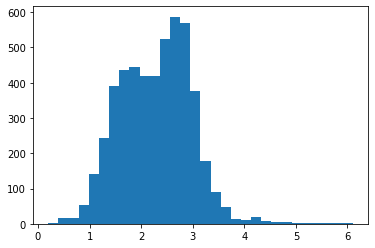

In [45]:
# Round up all the magnitudes

magnitudes=[];
for event in catalog.events:
    magnitudes.append(event.magnitudes[0].mag)

fig=plt.figure()    
ax = fig.add_axes()
plt.hist(magnitudes,axes=ax,bins=30)
#ax.set_ylabel('Number of Earthquakes')
#ax.set_xlabel('Magnitude')

# Plot up a b-value plot
magnitudes = np.array(magnitudes)

mag_bins = np.linspace(np.min(magnitudes),np.max(magnitudes))
bin_sums = []
for bin in mag_bins:
    bin_sums.append(np.sum(magnitudes[magnitudes>bin]))

#fig,ax = plt.plot(mag_bins,bin_sums)
#ax = plt.yscale(log)